In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
from datetime import datetime
from datetime import timedelta
import time
import warnings
warnings.filterwarnings('ignore')




# 0. Предобработка данных

На данном этапе мы осмотрим наши данные на наличие дубликатов, пропущенных значений и каких-либо закономерностей. 

In [3]:

df1 = pd.read_csv('auth_data.csv', sep=';')
df2 = pd.read_csv('reg_data.csv', sep=';')

In [4]:
df1.head()


,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [70]:
df1.isna().sum()


auth_ts    0
uid        0
dtype: int64

In [71]:
df1.duplicated().sum()

0

In [5]:
df2.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [72]:
df2.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [73]:
df2.duplicated().sum()

0

Как мы видим, никаких пропусков и дубликатов нет. Данные считались нормально. Сразу же замечаем, что можно соединить наши данные по столбцу uid, который в данном случае обозначает индивидуальный номер пользователя.

In [4]:
df = df1.merge(df2, on='uid')

In [41]:
df.head()

,auth_ts,uid,reg_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932921206,2,932683089
3,933393015,2,932683089
4,933875379,2,932683089


Здесь у нас auth_ts и reg_ts обозначают дату аутентификации и дату регистрации соответственно. Нетрудно заметить, что привычная нам дата закодирована в timestamp-формате.

In [42]:
df['auth_ts'] = df['auth_ts'].apply(datetime.fromtimestamp)
df['reg_ts'] = df['reg_ts'].apply(datetime.fromtimestamp)



In [43]:
# Теперь у нас готовый датафрейм. Можно приступать к анализу.
df.head()

,auth_ts,uid,reg_ts
0,1998-11-18 12:43:43,1,1998-11-18 12:43:43
1,1999-07-23 01:38:09,2,1999-07-23 01:38:09
2,1999-07-25 19:46:46,2,1999-07-23 01:38:09
3,1999-07-31 06:50:15,2,1999-07-23 01:38:09
4,1999-08-05 20:49:39,2,1999-07-23 01:38:09


# 1. Предположим, что данные - это сведения о аутентификации и регистрации пользователя в мобильной. Компания у нас небольшая, средств для подключения к продвинутым аналитическим платформам нет. Прежде всего нам необходимо знать наш retention по определённому промежутку времени(пусть по дням). 

Нам необходима такая функция, которая в любой момент времени при обращении к ней, могла на основании любого датафрейма построить график retention по дням. 

In [47]:
df[['reg_ts', 'auth_ts']].max()

reg_ts    2020-09-23 18:17:24
auth_ts   2020-09-23 18:17:24
dtype: datetime64[ns]

In [105]:
def retention(period, 
              data, 
              start_date, 
              end_date, 
              user_id, 
              cmap = ['#B0E0E6', '#1E90FF', '#0000FF']
             ):
    
    '''
    : param period: период анализа, указывать в формате str. Если период больше 31 дня - ошибка.
    : param data: набор данных в формате pd.DataFrame.
    : param start_date: колонка с датой начала, указывать в формате str.
    : param end_date: колонка с датой окончания, указывать в формате str.
    : param user_id: колонка с идентификаторами пользователей, указывать в формате str.
    : param cmap: по умолчанию 3 оттенка синего.
    : return heatmap 
    '''
    period = period
    days_df = data.query("reg_ts > = @period")
    
    days_df[start_date] = pd.to_datetime(days_df[start_date].dt.date)
    days_df[end_date] = pd.to_datetime(days_df[end_date].dt.date)
    days_df['delta'] = days_df[end_date] - days_df[start_date]
    pivot = days_df.pivot_table(index = start_date, columns = 'delta', values = user_id, aggfunc = 'nunique')
    pivot = round(pivot.divide(pivot.iloc[: , 0], axis = 'index').iloc[:-1, 1:], 4)
    
    if days_df['delta'].max() <= pd.Timedelta('7 days 00:00:00'):
        plt.figure(figsize = (15, 10))
        sns.heatmap(pivot, 
                    annot = True, 
                    xticklabels = pivot.columns.astype('str'), 
                    yticklabels = pivot.index.astype('str'),
                    cmap = cmap,
                    fmt='.2%',
                    annot_kws = dict(
                        color = 'black',
                        fontsize = 16),
                    linewidth = 1,
                    linecolor = 'white',
                    cbar_kws = dict(
                        extend = 'min',
                        ticks = np.arange(1, 1)))
        plt.xlabel(' ')
        plt.ylabel(' ')
        plt.xticks(color = 'black',
                   fontsize = 16,
                   rotation = 90)
        plt.yticks(rotation = 0,
                   color = 'black',
                   fontsize = 16)
        plt.title(label = f'''Когортный анализ за {days_df['delta'].max().days} дней''',
                  color = 'black',
                  fontsize = 20,
                  x = 0.5)
        plt.show()
        
    elif days_df['delta'].max() <= pd.Timedelta('14 days 00:00:00'):
        plt.figure(figsize = (20, 12))
        sns.heatmap(pivot, 
                    annot = True, 
                    xticklabels = pivot.columns.astype('str'), 
                    yticklabels = pivot.index.astype('str'),
                    cmap = ['#B0E0E6', '#87CEFA', '#1E90FF', '#4169E1', '#0000FF'],
                    fmt='.2%',
                    annot_kws = dict(
                        color = 'black',
                        fontsize = 14),
                    linewidth = 1,
                    linecolor = 'white',
                    cbar_kws = dict(
                        extend = 'min',
                        ticks = np.arange(1, 1)))
        plt.xlabel(' ')
        plt.ylabel(' ')
        plt.xticks(color = 'black',
                   fontsize = 16,
                   rotation = 90)
        plt.yticks(rotation = 0,
                   color = 'black',
                   fontsize = 16)
        plt.title(label = f'''Когортный анализ за {days_df['delta'].max().days} дней''',
                  color = 'black',
                  fontsize = 24,
                  x = 0.5)
        plt.show()
    elif days_df['delta'].max() > pd.Timedelta('31 days 00:00:00'):
        print('Слишком большой период, пожалуйста укажите период не больше 31 дня')
    else:
        plt.figure(figsize = (30, 20))
        sns.heatmap(pivot, 
                    annot = True, 
                    xticklabels = pivot.columns.astype('str'), 
                    yticklabels = pivot.index.astype('str'),
                    cmap = ['#B0E0E6', '#87CEFA', '#1E90FF', '#4169E1', '#0000FF'],
                    fmt='.2%',
                    annot_kws = dict(
                        color = 'black',
                        fontsize = 12),
                    linewidth = 1,
                    linecolor = 'white',
                    cbar_kws = dict(
                        extend = 'min',
                        ticks = np.arange(1, 1)))
        plt.xlabel(' ')
        plt.ylabel(' ')
        plt.xticks(color = 'black',
                   fontsize = 16,
                   rotation = 90)
        plt.yticks(rotation = 0,
                   color = 'black',
                   fontsize = 16)
        plt.title(label = f'''Когортный анализ за {days_df['delta'].max().days} дней''',
                  color = 'black',
                  fontsize = 34,
                  x = 0.5)
        plt.show()

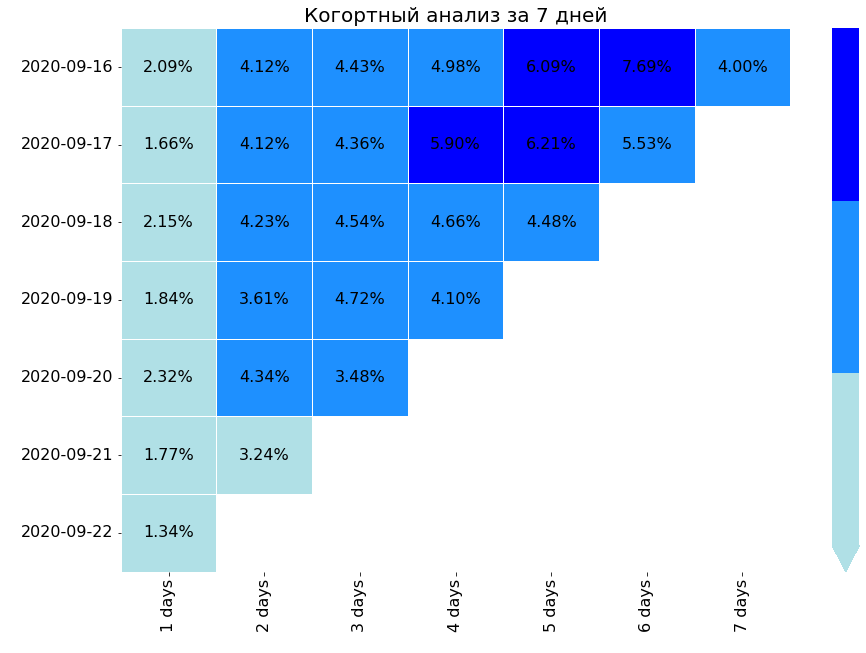

In [67]:
# Теперь можно ввести необходимую дату и получить retention по дням вплоть до последней даты.
# Например, возьмём период за 7 дней до последней даты.
retention(
    period = '2020-09-16',
    data = df,
    start_date = 'reg_ts',
    end_date = 'auth_ts',
    user_id = 'uid')

Таким образом, мы берём когорту всех пользователей, зарегистрировавшихся в определённое время, которые вернулись на следующий день.

# 2. Компания провела несколько наборов акционных предложений.   Имеются следующие данные A/B теста:
1) ARPU в тестовой группе больше на 5%, чем в контрольной

2) При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой результат нам следует расценивать как лучший? Какие метрики при этом использовать? Необходимо подробнее разобраться на самом датафрейме 

In [7]:
data = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q', sep=';')

Снова прибегнем к EDA

In [8]:
data

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [9]:
data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [10]:
data.duplicated().sum()

0

Таким образом, у нас вновь чистые данные, где колонки обозначают следующее:
1) Идентификатор пользователя

2) Выручка, которую принес пользователь

3) Принадлежность к группе


#  Необходимые метрики
1) Конверсия - сравним конверсию в разрезе групп и проверим стат. значимость с помощью хи-квадрат.

2) ARPU - сравним ARPU в разрезе групп и проверим стат. значимость с помощьюе параметрических/не параметрических тестов

3) ARPPU - сравним ARPPU в разрезе групп и проверим стат. значимость с помощьюе параметрических/не параметрических тестов

Также следует проверить данные на истинность согласно данным условиях.

In [11]:
summa = data.groupby('testgroup', as_index=False).agg({'revenue': 'sum'})

In [12]:
summa

,testgroup,revenue
0,a,5136189
1,b,5421603


In [13]:
# revenue дейсвтительно в тестовой группе b больше примерно на 5%
5421603 / 5136189

1.055569216786999

In [14]:
group_by_group = data \
    .groupby('testgroup', as_index = False) \
    .agg({'user_id' : 'count'}) \
    .rename(columns = {'user_id' : 'count'})

In [15]:
# Видим, что количество пользователей в обеих группах примерно одинаково
group_by_group

,testgroup,count
0,a,202103
1,b,202667


# Конверсия
Нам нужна колонка, которая покажет делал ли пользователь покупку в рамках эксперимента


In [16]:

purchases = []
for i in data['revenue']:
    if i == 0:
        x = 'no'
    else:
        x = 'yes'
    purchases.append(x)
data['purchase'] = purchases
data.head()

,user_id,revenue,testgroup,purchase
0,1,0,b,no
1,2,0,a,no
2,3,0,a,no
3,4,0,b,no
4,5,0,b,no


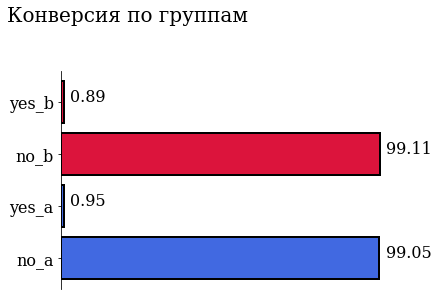

In [17]:
group_by_purchase_test = data \
    .groupby(['purchase', 'testgroup'], as_index = False) \
    .agg({'user_id' : 'count'}) \
    .rename(columns = {'user_id' : 'count'}) \
    .sort_values('testgroup') \
    .reset_index(drop = True)
group_by_purchase_test['combination'] = group_by_purchase_test['purchase'] + '_' + group_by_purchase_test['testgroup']
group_by_purchase_test['percentage'] = round(group_by_purchase_test['count'][:2] / group_by_purchase_test['count'][:2].sum() * 100, 2)
group_by_purchase_test['percentage'][2:] = round(group_by_purchase_test['count'][2:] / group_by_purchase_test['count'][2:].sum() * 100, 2)

plt.barh(y = group_by_purchase_test['combination'],
         width = group_by_purchase_test['percentage'],
         color = ['royalblue', 'royalblue', 'crimson', 'crimson'],
         height = 0.8,
         edgecolor = 'black',
         linewidth = 2)

sns.despine(bottom = True)

plt.xticks([])
plt.yticks(color = 'black',
           fontsize = 16,
           family = 'serif')

for i in range(len(group_by_purchase_test)):
    plt.text(s = group_by_purchase_test['percentage'][i],
             x = group_by_purchase_test['percentage'][i] + 2,
             y = i,
             color = 'black',
             fontsize = 16,
             family = 'serif')
    
plt.title(label = 'Конверсия по группам',
          color = 'black',
          fontsize = 20,
          x = 0.2,
          y = 1.2,
          family = 'serif')

plt.show()

In [18]:
alpha = 0.05
stat, p = stats.chi2_contingency(pd.crosstab(data['testgroup'], data['purchase']))[:2]
if p < alpha:
    print('Нулевая гипотеза отклоняется, есть стат. значимое влияние')
else:
    print('Нулевая гипотеза не отклоняется, нет стат. значимого влияния')

Нулевая гипотеза отклоняется, есть стат. значимое влияние


Таким образом, набор акционных предложений для группы a оказал влияние на желание пользователей совершать покупки. 

# ARPU / ARPPU

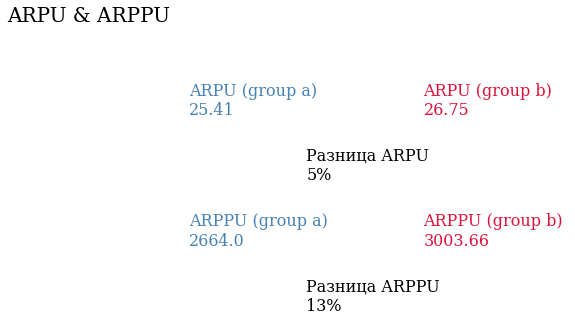

In [19]:
arpu_by_group = round(data \
    .groupby('testgroup', as_index = False) \
    .agg({'revenue' : 'mean'}), 2)

arppu_by_group = round(data \
    .query('revenue > 0') \
    .groupby('testgroup', as_index = False) \
    .agg({'revenue' : 'mean'}), 2)

plt.figure()

plt.text(s = f'''ARPU (group a) 
{arpu_by_group['revenue'][0]}''',
           color = 'steelblue',
           fontsize = 16,
           x = 0.5,
           y = 0.8,
           family = 'serif')

plt.text(s = f'''ARPU (group b) 
{arpu_by_group['revenue'][1]}''',
           color = 'crimson',
           fontsize = 16,
           x = 1.2,
           y = 0.8,
           family = 'serif')

plt.text(s = f'''Разница ARPU
{round(abs((arpu_by_group['revenue'][0]-arpu_by_group['revenue'][1]) / arpu_by_group['revenue'][0] * 100))}%''',
           color = 'black',
           fontsize = 16,
           x = 0.85,
           y = 0.5,
           family = 'serif')

plt.text(s = f'''ARPPU (group a) 
{arppu_by_group['revenue'][0]}''',
           color = 'steelblue',
           fontsize = 16,
           x = 0.5,
           y = 0.2,
           family = 'serif')

plt.text(s = f'''ARPPU (group b) 
{arppu_by_group['revenue'][1]}''',
           color = 'crimson',
           fontsize = 16,
           x = 1.2,
           y = 0.2,
           family = 'serif')

plt.text(s = f'''Разница ARPPU
{round(abs((arppu_by_group['revenue'][0]-arppu_by_group['revenue'][1]) / arppu_by_group['revenue'][0] * 100))}%''',
           color = 'black',
           fontsize = 16,
           x = 0.85,
           y = -0.1,
           family = 'serif')

plt.axis('off')

plt.title(label = 'ARPU & ARPPU',
          color = 'black',
          fontsize = 20,
          x = 0.2,
          y = 1.2,
          family = 'serif')

plt.show()

Из графика видно, что средняя выручка на пользователя и платящего пользователя больше в группе b. Теперь исследуем распределения выручки.



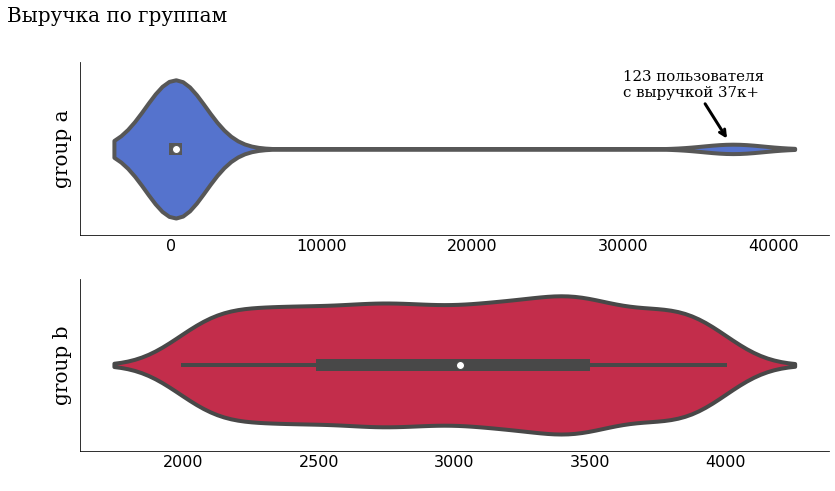

Группа a:
мин. выручка = 200
макс. выручка - 37433
медиана - 311.0

Группа b:
мин. выручка = 2000
макс. выручка - 4000
медиана - 3022.0



In [22]:
fig = plt.figure(figsize = (13, 3))

ax0 = fig.add_axes([0, 0, 0.8, 0.8])
ax1 = fig.add_axes([0, -1, 0.8, 0.8])

sns.violinplot(data.query("testgroup == 'a' & revenue > 0")['revenue'],
               ax = ax0,
               color = 'royalblue',
               edgecolor = 'black',
               linewidth = 4)

sns.violinplot(data.query("testgroup == 'b' & revenue > 0")['revenue'],
               ax = ax1,
               color = 'crimson',
               edgecolor = 'black',
               linewidth = 4)

ax0.annotate(text = f'''{len(data.query("testgroup == 'a' & revenue > 37000")['revenue'])} пользователя
с выручкой 37к+''',
             fontsize = 15,
             color = 'black',
             family = 'serif',
             xy = (37000, -0.05), 
             xytext = (30000, -0.3),
             arrowprops = dict(
                 color = 'black', 
                 arrowstyle = '->', 
                 connectionstyle = 'arc3,rad=-0.',
                 lw = 3)
            )

ax0.set_xlabel(' ')
ax1.set_xlabel(' ')
ax0.set_ylabel('group a',
               fontsize = 20,
               family = 'serif')
ax1.set_ylabel('group b',
               fontsize = 20,
               family = 'serif')

ax0.tick_params(length = 0, 
                width = 0, 
                colors = 'black', 
                labelsize = 16)
ax1.tick_params(length = 0, 
                width = 0, 
                colors = 'black', 
                grid_color = 'black', 
                labelsize = 16)


sns.despine()

ax0.set_title(label = 'Выручка по группам',
          color = 'black',
          fontsize = 20,
          x = 0.05,
          y = 1.2,
          family = 'serif')

plt.show()

for i in ['a', 'b']:
    print(f'''Группа {i}:
мин. выручка = {data.query("testgroup == @i & revenue > 0")['revenue'].min()}
макс. выручка - {data.query("testgroup == @i & revenue > 0")['revenue'].max()}
медиана - {data.query("testgroup == @i & revenue > 0")['revenue'].median()}''')
    print()


# Результаты анализа выручки:

1) В группе а размах выручки в разы больше, чем размах в группе b.

2) Распределение выручки в группе b более равномерно. В группе а пользователи совершают либо недорогие покупки, либо небольшая часть очень дорогие покупки.

3) Различная модель поведения пользователей.

4) Медианная выручка группы b примерно в 10 раз больше медианной выручки группы a.
 
# Чтобы определить имеется ли стат. значимая разница ARPU\ARPPU между группами будем использовать t-test и bootstrap (mean).

Применение параметрических методов обусловлено следующим:

1) Вышеуказанные методы проверяют наличие стат. значимой разницы метрики из задания

2) Большое кол-во наблюдений

3) Результаты t-test и bootstrap (mean) легче интерпретировать

4) Непараметрические методы не учитывают специфику распределений (в группе а имеют значительные группа пользователей, которые принесли в разы больше выручки, чем среднестатистический пользователь - не случайность)

# ARPU

t-test

In [24]:
alpha = 0.05
p = stats.ttest_ind(data.query("testgroup == 'a'")['revenue'], data.query("testgroup == 'b'")['revenue'], 
                    equal_var = False)[1]
print(p)
if p < alpha:
    print('Нулевая гипотеза о равенстве средних отклонена')
else:
    print('Нуелвая гипотеза о равенстве средних не отклонена')

0.5329647014130866
Нуелвая гипотеза о равенстве средних не отклонена


t-test показал, что нет стат. значимой разницы между ARPU группы а и группы b.

Теперь проверим равенство средних с помощью bootstrap.


In [27]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    print('p-value = ', p_value)
    
boodet_data_mean = get_bootstrap(
    data_column_1 = data.query("testgroup == 'a'")['revenue'], 
    data_column_2 = data.query("testgroup == 'b'")['revenue'], 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
)

p-value =  0.5227531708364697


 bootstrap также показал, что нет стат. значимой разницы между средними выручки.

# Можем сделать вывод, что различия в акционных наборах не оказали влияние на ARPU.


## ARPPU



In [30]:
p = stats.ttest_ind(data.query("testgroup == 'a' & revenue > 0")['revenue'], data.query("testgroup == 'b' & revenue > 0")['revenue'], 
                    equal_var = False)[1]
print(p)
if p < alpha:
    print('Нулевая гипотеза о равенстве средних отклонена')
else:
    print('Нуелвая гипотеза о равенстве средних не отклонена')

0.10020780398916015
Нуелвая гипотеза о равенстве средних не отклонена


t-test показал, что между ARPPU групы а и группы b нет стат. значимых различий.

In [31]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    print('p-value = ', p_value)
    
boodet_data_mean = get_bootstrap(
    data_column_1 = data.query("testgroup == 'a' & revenue > 0")['revenue'], 
    data_column_2 = data.query("testgroup == 'b' & revenue > 0")['revenue'], 
    boot_it = 1000, 
    statistic = np.mean, 
    bootstrap_conf_level = 0.95 
)

p-value =  0.1120160211446152


Согласно bootstrap мы также не можем отклонить нулевую гипотезу.

Можем сделать вывод, что набор акционных предложений не оказал стат. значимого влияния на ARPPU.

# Результаты:


 1) Различия между акционными наборами оказали стат. значимое влияние на желание пользователей совершать покупки - в группе а конверсия больше на 0.06%.


 2) Различное поведение пользователей в группах - выручка пользователей группы b распределена более равномерно, пользователи группы а в основном совершают более дешевые покупки, но есть исключение в виде группы из 123 пользователей, которые совершили очень дорогие покупки / либо много покупок.
 
 
 3) Различия между акционными наборами не оказали стат. значимого влияния на ARPU.
 
 4) Различия между акционными наборами не оказали стат. значимого влияния на ARPPU.
 

# Что следует предпринять?

Реализовать акционное предложение для группы b.


# 3. В игре X каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для дома и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? 

# Упрощенная механика:

DAU - сравнить кол-во пользователей в тематические дни и в обычные.

Sticky factor (недельный и месячный) - сравнить коэффициенты "липучести" в дни, когда проводятся проводятся тематические, события и в обычные дни.

ACU (hour) - определить период времени в сутках с наибольшим кол-вом пользователей, рассчитать среднее число пользователей за час, сравнить показатель с тематическими днями.

Относительная и абсолютная конверсии - позволят определить как проведение тематических событий сказывавается на привлечении новой аудитории.

ASL - сравнение средней продолжительности сессии в обычный день и тематический позволит определить как тематическое событие влияет на время, которое пользователь проводит в приложении.

Интервалы между сессиями - позволит определить имеется ли влияние тематических событий на желание пользователя возвращаться в игру (сравнить с обычным днём). 

# Усложненная механика:

Учитывая, что механика усложнилась и появился риск потерять exp, то в целом можем ожидать, что это негативно скажется на вышеописанных метриках. Соответственно, чтобы оценить его влияние нужно дополнительно учитывать следующие метрики:

Доля пользователей, которые вышли после первого неудачной попытки - неудачная попытка и откат это негативные события. Многим не нравится проигрывать, а откат является усилением негативного впечатления пользователя, сравнение значений позволит оценить насколько сильно оказывает влияние откат.

Cредняя продолжительность игры после неудачной попытки - позволит оценить влияние отката на желания пользователя продолжать игру.

Cреднее кол-во откатов - позволит оценить "терпение аудитории".